# Simple prediction using previous time step

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.append('..')

from lib.utils import *
from lib.loss import *
import glob
import warnings
import os
import datetime
from tqdm import tqdm, trange
import dill
import random
import time

In [2]:
fidelity = "low"
n = int(8352 * 0.2)

x = sorted(glob.glob(f"../../data/batch_{fidelity}_data/inputs_*"), key=sort_batch_fn)[-8568:-216]
y = sorted(glob.glob(f"../../data/batch_{fidelity}_data/outputs_*"), key=sort_batch_fn)[-8568:-216]

l2_x_train = x[:len(x)//5]
l2_y_train = y[:len(x)//5]

l2_x_val = x[-len(x)//5:]
l2_y_val = y[-len(x)//5:]

In [3]:
l2_x_scaler_minmax = dill.load(open(f'../../data/scaler/{fidelity}_x_minmax_scaler.pkl', 'rb'))
l2_y_scaler_minmax = dill.load(open(f'../../data/scaler/{fidelity}_y_minmax_scaler.pkl', 'rb'))
l2_x_scaler_standard = dill.load(open(f'../../data/scaler/{fidelity}_x_standard_scaler.pkl', 'rb'))
l2_y_scaler_standard = dill.load(open(f'../../data/scaler/{fidelity}_y_standard_scaler.pkl', 'rb')) 

In [16]:
def get_stats(y_path):
    mae_total = 0
    mse_total = 0
    non_mae_total = 0
    norm_rmse_total = 0
    non_norm_rmse_total = 0


    for i in trange(len(y_path)-1):
        y = np.load(y_path[i])
        y_pred = np.load(y_path[i+1])

        non_y = y
        non_y_pred = y_pred

        y = l2_y_scaler_minmax.transform(y)
        y_pred = l2_y_scaler_minmax.transform(y_pred)

        mse = mse_metric(y_pred, y)
        mae = mae_metric(y_pred, y)
        non_mae = mae_metric(non_y_pred, non_y)
        norm_rmse = norm_rmse_loss(y_pred, y, metric=True).mean()
        non_norm_rmse = norm_rmse_loss(non_y_pred, non_y, metric=True).mean()

        mse_total += mse
        mae_total += mae
        non_mae_total += non_mae
        norm_rmse_total += norm_rmse
        non_norm_rmse_total += non_norm_rmse

        if i == 0:
            metrics = [[mse], [mae], [non_mae], [norm_rmse], [non_norm_rmse]]
        else:
            metrics[0].append(mse)
            metrics[1].append(mae)
            metrics[2].append(non_mae)
            metrics[3].append(norm_rmse)
            metrics[4].append(non_norm_rmse)
            
    mse_total /= i + 1
    mae_total /= i + 1
    non_mae_total /= i + 1
    norm_rmse_total /= i + 1
    non_norm_rmse_total /= i + 1
    return mse_total, mae_total, non_mae_total, norm_rmse_total, non_norm_rmse_total, metrics

In [17]:
mse, mae, non_mae, norm_rmse, non_norm_rmse, train_metrics = get_stats(l2_y_train)
mse, mae, non_mae, norm_rmse, non_norm_rmse

100%|██████████| 1669/1669 [00:59<00:00, 27.91it/s]


(0.00021951955954760196,
 0.0028664719753096818,
 0.6791043281555176,
 0.00017848222407246194,
 0.3032544896412817)

In [18]:
mse, mae, non_mae, norm_rmse, non_norm_rmse, valid_metrics = get_stats(l2_y_val)
mse, mae, non_mae, norm_rmse, non_norm_rmse

100%|██████████| 1670/1670 [01:01<00:00, 27.16it/s]


(0.0002105985783301238,
 0.0028431342437885655,
 0.6267946265771718,
 0.00018282315403977297,
 0.2544274369845847)

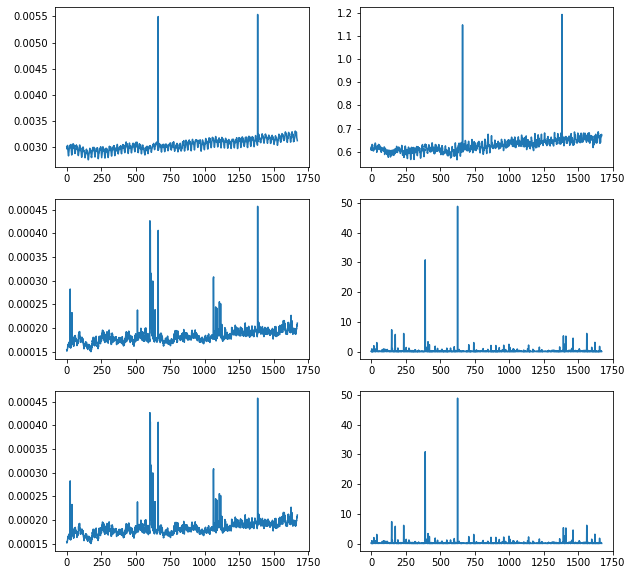

In [ ]:
x = np.arange(len(l2_y_train))
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
axs[0, 0].plot(x, train_metrics[0])
axs[0, 1].plot(x, train_metrics[1])
axs[1, 0].plot(x, train_metrics[2])
axs[1, 1].plot(x, train_metrics[3])
axs[2, 0].plot(x, train_metrics[4])
axs[2, 1].plot(x, train_metrics[5])
axs[3, 0].plot(x, train_metrics[6])